In [1]:
import spacy, os, io
from torch.utils.data import Dataset
from spacy.pipeline import Pipe
from nlpClasses import Vocabulary
import pandas as pd
import copy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [3]:
path = '/Users/ivoliv/data/gutenberg'
filename = '84-0.txt'

In [4]:
ff = io.open(os.path.join(path, filename), 'r', encoding='utf-8')
doc = nlp(ff.read())
ff.close()

In [5]:
WINDOW_LEN = 2

In [6]:
dataset = []
context_start = ['<PAD>' for i in range(2*WINDOW_LEN)]
for i, sent in enumerate(doc.sents):
    if i < 5: continue
    line = [tok.text.lower() for tok in sent if not tok.is_space and not tok.is_punct]
    if len(line) < 5: continue
    for w in range(len(line)):
        start = max(0, w-WINDOW_LEN)
        end = min(len(line), w+WINDOW_LEN+1)
        context_left = line[start:w]
        context_right = line[w+1:end]
        context = copy.deepcopy(context_start)
        context[WINDOW_LEN-len(context_left):2] = context_left
        context[2:2+len(context_right)] = context_right
        dataset.append((i-5, line[w], context))
    if i > 3275: break
frank_df = pd.DataFrame(dataset, columns=['sent_id', 'target', 'context'])
frank_df.head()

,sent_id,target,context
0,0,st.,"[<PAD>, <PAD>, petersburgh, dec.]"
1,0,petersburgh,"[<PAD>, st., dec., 11th]"
2,0,dec.,"[st., petersburgh, 11th, 17—.]"
3,0,11th,"[petersburgh, dec., 17—., you]"
4,0,17—.,"[dec., 11th, you, will]"


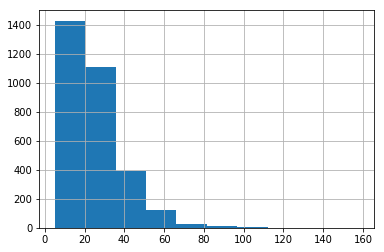

In [7]:
sents = frank_df['sent_id'].value_counts()
sents.hist()

In [8]:
sents.head()

2189    158
2741    105
636     104
1838    101
1633     93
Name: sent_id, dtype: int64

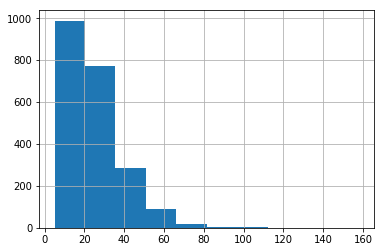

In [9]:
X_train, X_test = train_test_split(sents, test_size=0.30, random_state=123)
X_train.hist()

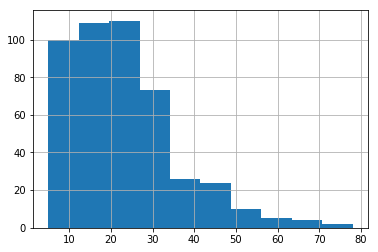

In [10]:
X_valid, X_test = train_test_split(X_test, test_size=0.50, random_state=234)
X_valid.hist()

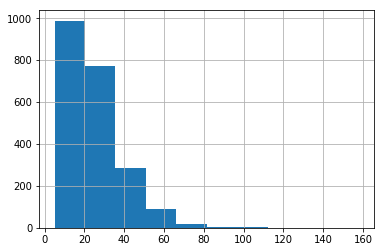

In [11]:
X_train.hist()

In [12]:
X_train.sort_index().index

Int64Index([   1,    2,    4,    7,   10,   11,   12,   13,   14,   15,
            ...
            3254, 3256, 3257, 3261, 3263, 3264, 3266, 3267, 3269, 3272],
           dtype='int64', length=2158)

In [13]:
train = pd.DataFrame(X_train.sort_index().index, columns=['sent_id'])
train['split'] = 'train'
valid = pd.DataFrame(X_valid.sort_index().index, columns=['sent_id'])
valid['split'] = 'valid'
test = pd.DataFrame(X_test.sort_index().index, columns=['sent_id'])
test['split'] = 'test'

In [14]:
train.head()

,sent_id,split
0,1,train
1,2,train
2,4,train
3,7,train
4,10,train


In [15]:
frank_df_split = pd.concat([train, valid, test]).sort_values('sent_id')
frank_df_split = pd.merge(frank_df, frank_df_split, on='sent_id')
frank_df_split.head()

,sent_id,target,context,split
0,0,st.,"[<PAD>, <PAD>, petersburgh, dec.]",test
1,0,petersburgh,"[<PAD>, st., dec., 11th]",test
2,0,dec.,"[st., petersburgh, 11th, 17—.]",test
3,0,11th,"[petersburgh, dec., 17—., you]",test
4,0,17—.,"[dec., 11th, you, will]",test


In [16]:
frank_df_split['split'].value_counts()

train    52769
test     11425
valid    10645
Name: split, dtype: int64

In [17]:
frank_df_split['split'].value_counts(normalize=True)

train    0.705100
test     0.152661
valid    0.142239
Name: split, dtype: float64

In [18]:
frank_df_split.to_csv('../data/frank_df.csv', index=False)